# Wonderful Wines of the World

## Initial Setup

In [1]:
## import libraries

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

import os
from math import ceil



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm


In [3]:
from sklearn.base import clone

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, FactorAnalysis

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth


from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import graphviz


In [4]:
import warnings
warnings.filterwarnings('ignore')

# https://stackoverflow.com/questions/56618739/matplotlib-throws-warning-message-because-of-findfont-python
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# importing sompy enables more logging
logging.disable(logging.INFO)

In [5]:
#!pip install kneed

In [6]:
from kneed import KneeLocator

In [7]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)


Pandas version  1.3.3
Numpy version  1.20.3
Scipy version  1.7.0
Seaborn version  0.11.2


## Define some constant variables

In [8]:
COLORS = ['#7a2b5d', '#975c86', '#b38dad', '#d0bed6', '#edf0ff', '#eae1cd', '#e8d19a', '#e6c064', '#e3ae29']
CAT_COLORS = ['#7a2b5d', '#4475B0', '#21BFAB', '#EBBD53', '#EF5072']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = COLORS.copy()

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)

sns.set_palette(DEFAULT_PALETTE)

DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True


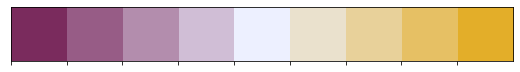

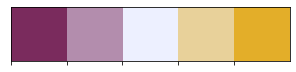

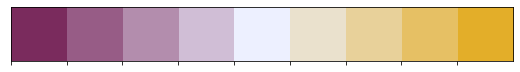

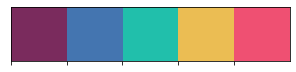

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

In [10]:
sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 70

In [11]:
show_plots = True
img_counter = 0
random_state = 0

IMG_PATH = '../../out/imgs/'

## Define some functions

In [12]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight')
        


In [13]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [14]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL ["+ colname + "].")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL ["+ colname + "].")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




## Load Dataset

In [15]:
df = pd.read_excel('../data/WonderfulWinesoftheWorld.xlsx')
df_original = df.copy(deep=True)

## Remove last row
df.drop(df.tail(1).index,inplace=True)
df['Custid'] = df['Custid'].astype(int)
df.set_index('Custid', inplace=True)

df.head(3)

Dayswus   Age   Edu    Income  Freq  Recency  Monetary    LTV  \
Custid                                                                  
5325      653.0  55.0  20.0   78473.0  20.0     18.0     826.0  445.0   
3956     1041.0  75.0  18.0  105087.0  36.0     33.0    1852.0  539.0   
3681      666.0  18.0  12.0   27984.0   4.0     56.0      39.0   -7.0   

        Perdeal  Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic  \
Custid                                                               
5325        7.0    67.0       4.0   26.0      2.0      1.0     1.0   
3956        2.0    49.0       0.0   46.0      1.0      3.0     0.0   
3681       88.0     4.0      29.0   14.0     32.0     21.0    48.0   

        WebPurchase  WebVisit  
Custid                         
5325           36.0       5.0  
3956           20.0       4.0  
3681           60.0       8.0

In [16]:
df.describe().to_csv('../../out/data/data_summary.csv')

## Data Understanding

### Check datatypes

In [17]:
df.dtypes

Dayswus        float64
Age            float64
Edu            float64
Income         float64
Freq           float64
Recency        float64
Monetary       float64
LTV            float64
Perdeal        float64
Dryred         float64
Sweetred       float64
Drywh          float64
Sweetwh        float64
Dessert        float64
Exotic         float64
WebPurchase    float64
WebVisit       float64
dtype: object

All variables are numeric.

### Check for duplicates

In [18]:
print(df[df.duplicated(keep=False)])

Empty DataFrame
Columns: [Dayswus, Age, Edu, Income, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit]
Index: []


### Identify features for segmentation

In [19]:
## Wine preference features
wine_features = ['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']

## Value segmentation features
value_features = ['Dayswus', 'Freq', 'Recency', 'Monetary', 'LTV', 'Perdeal']

## Separate Demographic features for cluster descriptions later
demog_features = ['Age', 'Edu', 'Income']

## Separate other features
other_features = ['WebPurchase', 'WebVisit']


### Distributions of values for variables

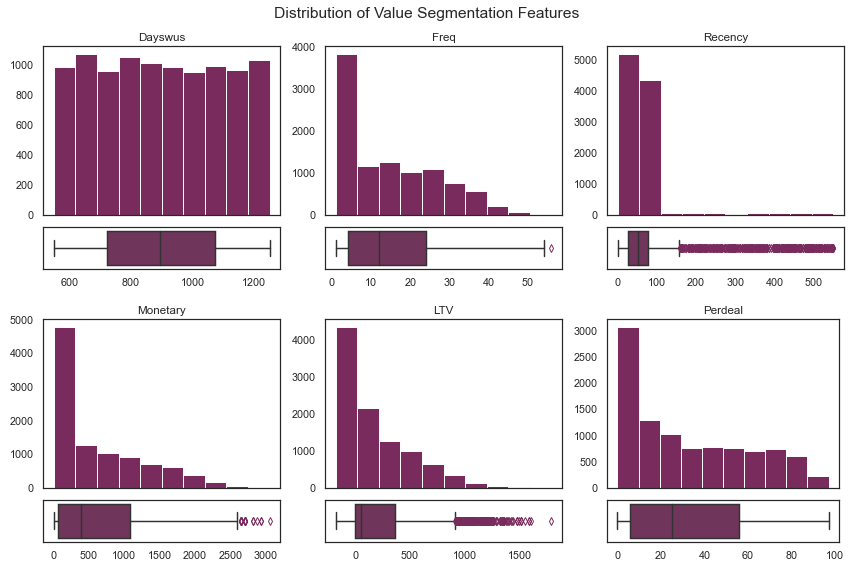

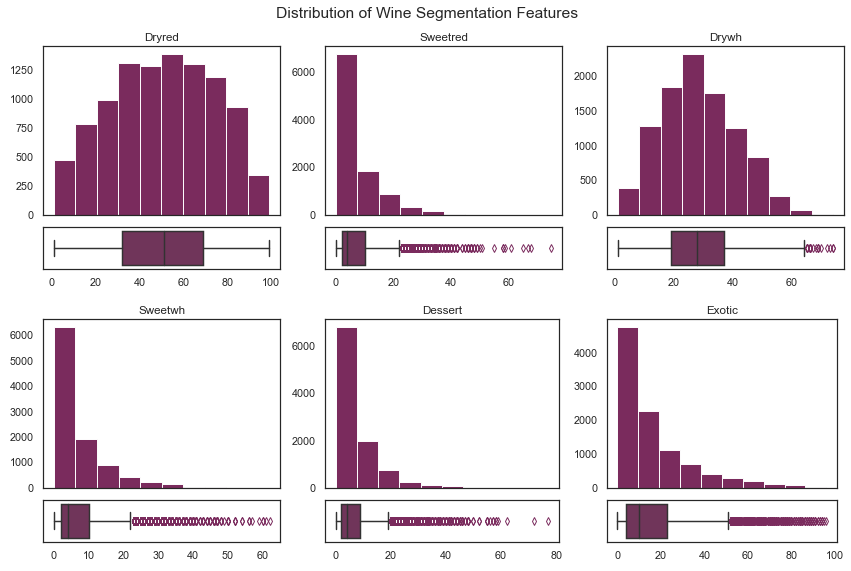

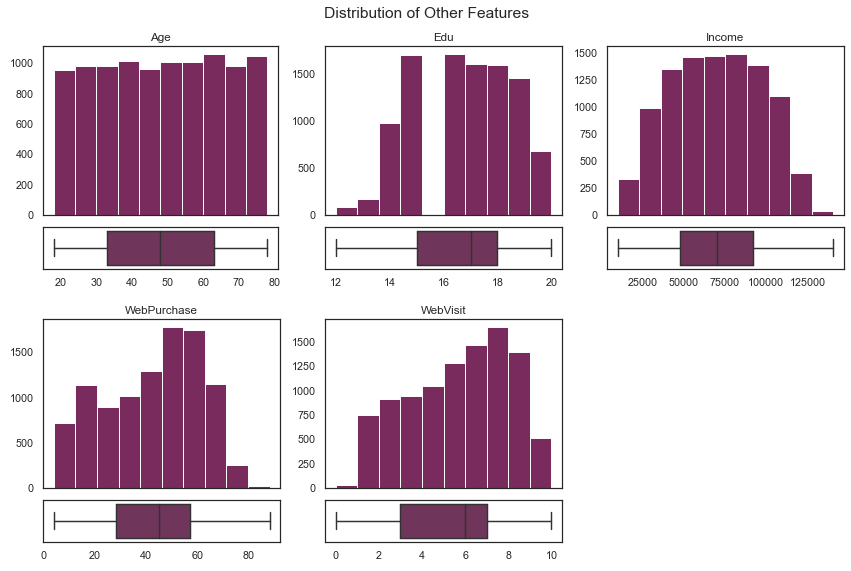

In [20]:
plot_histograms_boxplots(df, value_features, rows=2, title='Distribution of Value Segmentation Features')
plot_histograms_boxplots(df, wine_features, rows=2, title='Distribution of Wine Segmentation Features')
plot_histograms_boxplots(df, (demog_features+other_features), rows=2, title='Distribution of Other Features')

## Data Preparation

### Check for correlation

In [21]:
def make_corr_heatmap(df, method, title="Triangle Correlation Heatmap"):
    l = len(df.columns.tolist())
    fig = plt.figure(figsize=(2*l, 1.5*l))
    mask = np.triu(np.ones_like(df.corr(method=method), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=method), mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f' ,cmap=DIV_CMAP)
    heatmap.set_title(title, fontdict={'fontsize':18}, pad=2);
    save_fig(title, fig)
    plt.show()

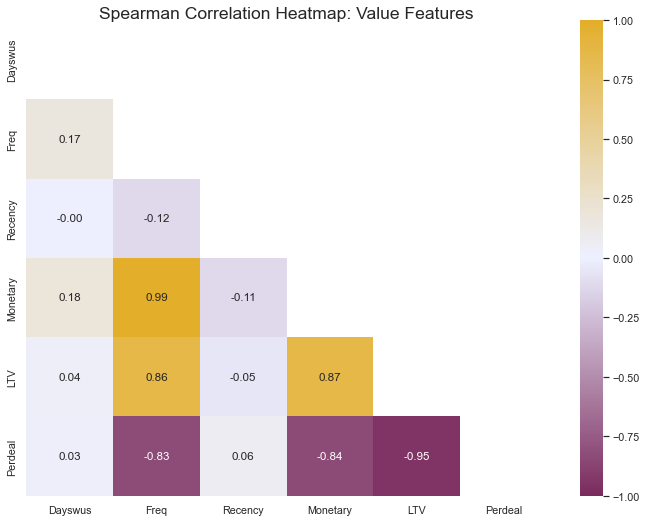

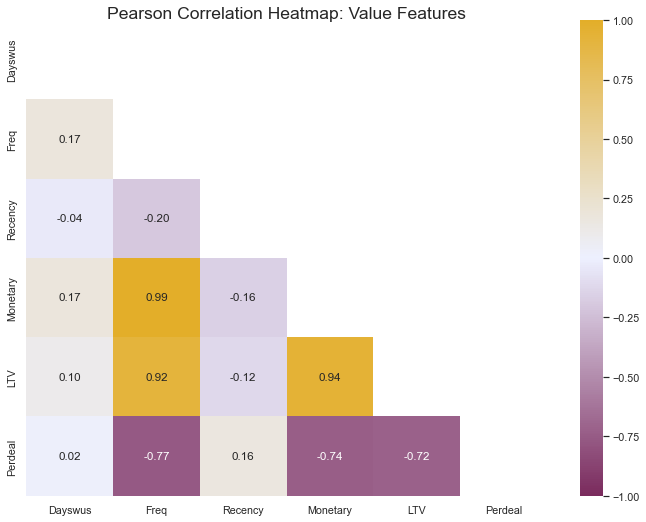

In [22]:
make_corr_heatmap(df[value_features], 'spearman', title="Spearman Correlation Heatmap: Value Features")
make_corr_heatmap(df[value_features], 'pearson', title="Pearson Correlation Heatmap: Value Features")


In [23]:
## Remove Perdeal because highly correlated with multiple feats
value_features.remove('Perdeal')
other_features.append('Perdeal')

## Remove Monetary because highly correlated with Freq, LTV
value_features.remove('Monetary')
other_features.append('Monetary')


## Remove Frequency and LTV because highly correlated with Monetary
value_features2 = ['Dayswus', 'Recency', 'Monetary']

value_features

['Dayswus', 'Freq', 'Recency', 'LTV']

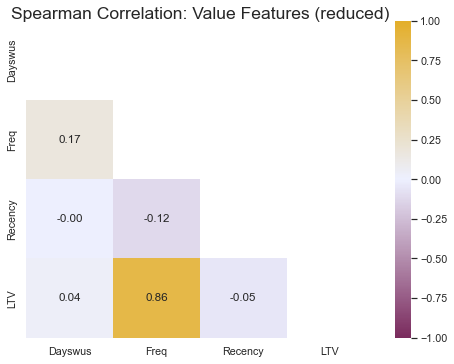

In [24]:
make_corr_heatmap(df[value_features], 'spearman', title="Spearman Correlation: Value Features (reduced)")


### Check for outliers

In [25]:
for v in df.columns.tolist():
    getIQR(df, v)

363 or 3.63% of rows are above the UL [Recency].
117 or 1.17% of rows are above the UL [LTV].
358 or 3.58% of rows are above the UL [Sweetred].
2 or 0.02% of rows are above the UL [Drywh].
365 or 3.65% of rows are above the UL [Sweetwh].
474 or 4.74% of rows are above the UL [Dessert].
331 or 3.31% of rows are above the UL [Exotic].


Too many outliers to remove just based on IQR

In [26]:
df['Outlier'] = 0

In [27]:
df.loc[df['Dessert']>70,['Outlier']] = 1
df.loc[df['Sweetred']>70,['Outlier']] = 1

In [28]:
df.loc[df['Freq']>55,['Outlier']] = 1
df.loc[df['LTV']>1750,['Outlier']] = 1

In [29]:
df_hasoutliers = df.copy()

In [30]:
df = df[df['Outlier']==0]

In [31]:
df_outliers = df[df['Outlier']==1]

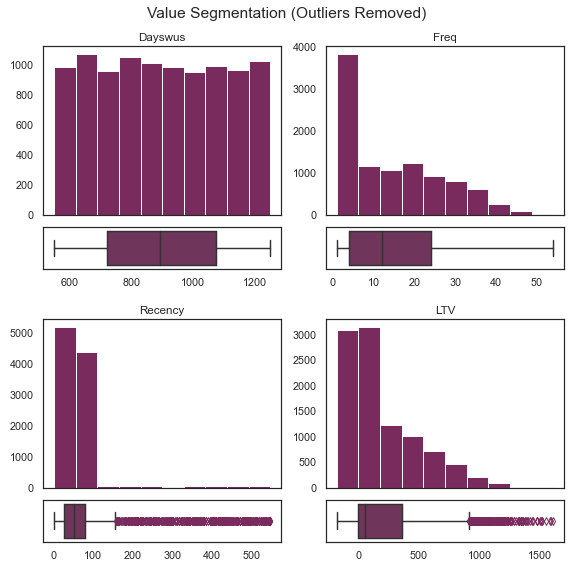

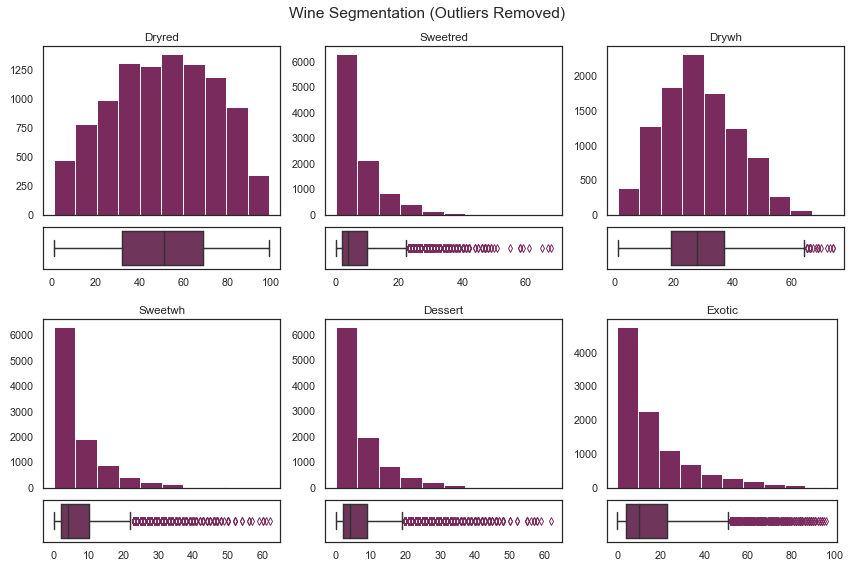

In [32]:
plot_histograms_boxplots(df, value_features, rows=2, title='Value Segmentation (Outliers Removed)')
plot_histograms_boxplots(df, wine_features, rows=2, title='Wine Segmentation (Outliers Removed)')

## Transform Variables

### MinMax Scaler

We only scale the Value Segmentation Features because the Wine Segmentation Features are all in the same scale (percentage) already.

In [33]:
mmscaler = MinMaxScaler()

value_feats_mm = value_features.copy()

for fi in range(len(value_feats_mm)):
    t = value_feats_mm[fi] + '_mm'
    value_feats_mm[fi] = t
    df[t] = df[value_features[fi]]

df[value_feats_mm] = mmscaler.fit_transform(df[value_feats_mm])


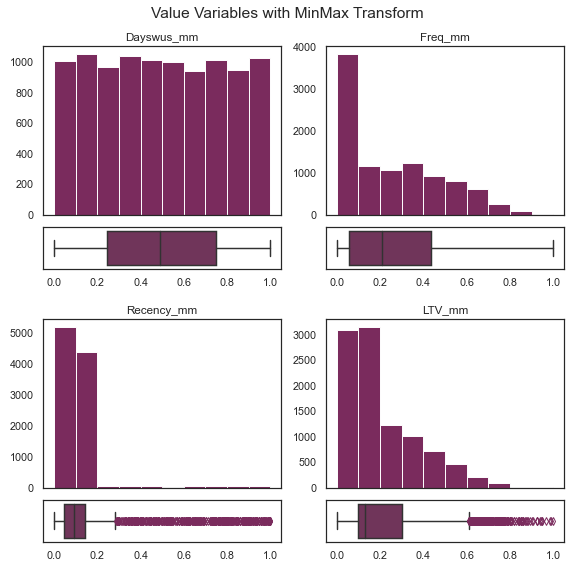

In [34]:
plot_histograms_boxplots(df, value_feats_mm, rows=2, title='Value Variables with MinMax Transform')


### Transform wine features to decimal (from percentage)

In [35]:
wine_feats_dec = wine_features.copy()

for fi in range(len(wine_feats_dec)):
    t = wine_feats_dec[fi] + '_dec'
    wine_feats_dec[fi] = t
    df[t] = df[wine_features[fi]]/100


## Use DBSCAN to identify 'noise' rows

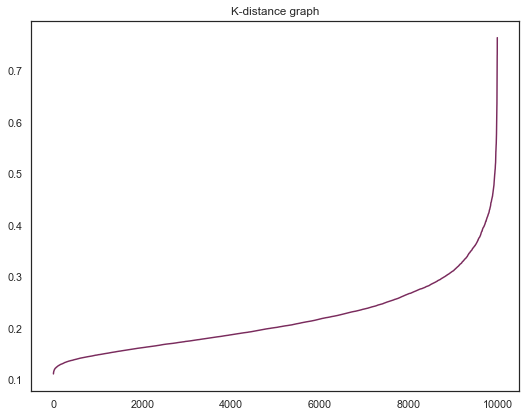

In [36]:
vars_ = wine_feats_dec + value_feats_mm
neigh = NearestNeighbors(n_neighbors=50)
neigh.fit(df[vars_])
distances, _ = neigh.kneighbors(df[vars_])
distances = np.sort(distances[:, -1])

fig, axis = plt.subplots(figsize=(9,7))
plt.plot(distances, color=COLORS[0])
plt.title('K-distance graph')
plt.show()

save_fig('K-distance graph', fig)

In [37]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=.35, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[vars_])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [38]:
# Concatenating the labels to df
df_dbscan = pd.concat([df[vars_], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_dbscan.groupby(['dbscan_labels']).count()

Dryred_dec  Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  \
dbscan_labels                                                                  
-1                     30            30         30           30           30   
 0                   9966          9966       9966         9966         9966   

               Exotic_dec  Dayswus_mm  Freq_mm  Recency_mm  LTV_mm  
dbscan_labels                                                       
-1                     30          30       30          30      30  
 0                   9966        9966     9966        9966    9966

In [39]:
df_ = pd.concat([df, pd.Series(dbscan_labels, index=df.index, name="Noise")], axis=1)
df_noise = df_.loc[df_['Noise'] == -1]
df = df_.loc[df_['Noise'] != -1]
df_nonoise = df_.loc[df_['Noise'] != -1]


In [40]:
df.drop(columns=['Noise'], inplace=True)
df

Dayswus   Age   Edu    Income  Freq  Recency  Monetary    LTV  \
Custid                                                                  
5325      653.0  55.0  20.0   78473.0  20.0     18.0     826.0  445.0   
3956     1041.0  75.0  18.0  105087.0  36.0     33.0    1852.0  539.0   
3681      666.0  18.0  12.0   27984.0   4.0     56.0      39.0   -7.0   
2829     1049.0  42.0  16.0   61748.0   2.0     46.0      37.0   -6.0   
8788      837.0  47.0  16.0   65789.0   2.0      3.0      36.0    4.0   
...         ...   ...   ...       ...   ...      ...       ...    ...   
1383     1132.0  57.0  20.0   81033.0  19.0     59.0     776.0  187.0   
4070      596.0  66.0  15.0   84714.0  18.0     45.0     720.0  391.0   
7909      619.0  18.0  12.0   40466.0   3.0     65.0      47.0    5.0   
4158     1107.0  33.0  16.0   53661.0   1.0    368.0      15.0    2.0   
4914      979.0  55.0  16.0   94926.0  25.0     28.0    1148.0  293.0   

        Perdeal  Dryred  ...  Dayswus_mm   Freq_mm  Recency_mm    LTV_mm  \
Custid                   ...                                               
5325        7.0    67.0  ...    0.147143  0.358491    0.032787  0.348824   
3956        2.0    49.0  ...    0.701429  0.660377    0.060109  0.401456   
3681       88.0     4.0  ...    0.165714  0.056604    0.102004  0.095745   
2829       70.0    86.0  ...    0.712857  0.018868    0.083789  0.096305   
8788       35.0    85.0  ...    0.410000  0.018868    0.005464  0.101904   
...         ...     ...  ...         ...       ...         ...       ...   
1383       22.0    78.0  ...    0.831429  0.339623    0.107468  0.204367   
4070        5.0    30.0  ...    0.065714  0.320755    0.081967  0.318589   
7909       23.0     6.0  ...    0.098571  0.037736    0.118397  0.102464   
4158       35.0    18.0  ...    0.795714  0.000000    0.670310  0.100784   
4914        7.0    63.0  ...    0.612857  0.452830    0.051002  0.263718   

        Dryred_dec  Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  \
Custid                                                                  
5325          0.67          0.04       0.26         0.02         0.01   
3956          0.49          0.00       0.46         0.01         0.03   
3681          0.04          0.29       0.14         0.32         0.21   
2829          0.86          0.01       0.11         0.01         0.01   
8788          0.85          0.00       0.12         0.02         0.01   
...            ...           ...        ...          ...          ...   
1383          0.78          0.00       0.20         0.01         0.01   
4070          0.30          0.12       0.36         0.10         0.12   
7909          0.06          0.24       0.10         0.38         0.22   
4158          0.18          0.13       0.45         0.11         0.13   
4914          0.63          0.10       0.13         0.11         0.03   

        Exotic_dec  
Custid              
5325          0.01  
3956          0.00  
3681          0.48  
2829          0.55  
8788          0.28  
...            ...  
1383          0.11  
4070          0.13  
7909          0.41  
4158          0.13  
4914          0.04  

[9966 rows x 28 columns]

In [41]:
print('Percentage of rows considered noise:')
100*len(df_dbscan.loc[df_dbscan['dbscan_labels'] == -1])/len(df)

Percentage of rows considered noise:


0.30102347983142685

## Summary of Variables

In [42]:
## Original value features
print(value_features)
df[value_features].head(3)

['Dayswus', 'Freq', 'Recency', 'LTV']


Dayswus  Freq  Recency    LTV
Custid                               
5325      653.0  20.0     18.0  445.0
3956     1041.0  36.0     33.0  539.0
3681      666.0   4.0     56.0   -7.0

In [43]:
## Original wine features
print(wine_features)
df[wine_features].head(3)

['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']


Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic
Custid                                                   
5325      67.0       4.0   26.0      2.0      1.0     1.0
3956      49.0       0.0   46.0      1.0      3.0     0.0
3681       4.0      29.0   14.0     32.0     21.0    48.0

In [44]:
## MinMax transformed value features
print(value_feats_mm)
df[value_feats_mm].head(3)

['Dayswus_mm', 'Freq_mm', 'Recency_mm', 'LTV_mm']


Dayswus_mm   Freq_mm  Recency_mm    LTV_mm
Custid                                            
5325      0.147143  0.358491    0.032787  0.348824
3956      0.701429  0.660377    0.060109  0.401456
3681      0.165714  0.056604    0.102004  0.095745

In [45]:
## Decimal wine features
print(wine_feats_dec)
df[wine_feats_dec].head(3)

['Dryred_dec', 'Sweetred_dec', 'Drywh_dec', 'Sweetwh_dec', 'Dessert_dec', 'Exotic_dec']


Dryred_dec  Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  \
Custid                                                                  
5325          0.67          0.04       0.26         0.02         0.01   
3956          0.49          0.00       0.46         0.01         0.03   
3681          0.04          0.29       0.14         0.32         0.21   

        Exotic_dec  
Custid              
5325          0.01  
3956          0.00  
3681          0.48

# Clustering

## Wine Segmentation

In [46]:
def showClusterHeatMap_final(df, label1, cols, title='Heatmap of Cluster Means'):
    fig, ax = plt.subplots(constrained_layout=True , figsize=(len(cols)*1.4,len(cols)*.8), sharey=True)
    
    label_counts = df.groupby(label1)[label1].count()
    
    xticks = [(str(l) + "\n" + str(label_counts[l])) for l in range(len(label_counts))]
    
    sns.heatmap(df.groupby(label1)[cols].mean().loc[range(0,len(label_counts)),:].T, \
            vmin=0, vmax=1,
            cmap='PiYG', xticklabels=xticks, annot=True, fmt='.2f', annot_kws={"fontsize":16})


    ax.set_xlabel('Cluster Sizes and Labels, K=')
    fig.suptitle(title, y=1.1, fontsize=20)
    
    if SAVE_PLOTS:
        save_fig(title, fig)
    
    plt.show()


### K-means

In [47]:
whinedf_kmeans=df_nonoise[wine_feats_dec].copy() 

In [48]:
def showElbowSilhouette(df, features, max_k=40):
    n_clusters = range(2,max_k)
    silhouette_scores = []
    sum_squared_dist = []

    for num_clusters in n_clusters:
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=1500,n_init=100,random_state=0)
        
        kmeans.fit(df[features])
        cluster_labels = kmeans.labels_
        sum_squared_dist.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(df[features], cluster_labels,\
                                                  metric='euclidean', \
                                                  sample_size=None, random_state=None))
    
    fig, ax1 = plt.subplots(figsize=(15,7))
    #ax2 = ax1.twinx()

    ax1.plot(n_clusters,sum_squared_dist, color=COLORS[0], label='Inertia')
    #ax2.plot(n_clusters, silhouette_scores, color=CAT_COLORS[1], label='Silhouette', linestyle='dashed')
    
    ax1.set_xlabel('Values of K')
    ax1.set_ylabel('Inertia')#, color=COLORS[0])
    #ax2.set_ylabel('Silhouette Score', color=COLORS[1])
    
    kl = KneeLocator(range(1, len(sum_squared_dist)+1), sum_squared_dist, curve="convex", direction="decreasing")
    ax1.axvline(x=kl.elbow, label='Elbow', color=COLORS[1], linestyle='dashed')
    
    fig.legend(loc="upper right", bbox_to_anchor=(.85, .85))
    plt.xticks(range(1,max_k+1,2))
    plt.title('Inertia Plot')
    save_fig('Inertia Plot', fig)
    
    

    plt.show()

    print('Knee located at k=', kl.elbow)
    


In [49]:
sns.set_palette(DEFAULT_PALETTE)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1500,n_init=100,random_state=0)
    kmeans.fit(whinedf_kmeans)
    wcss.append(kmeans.inertia_)

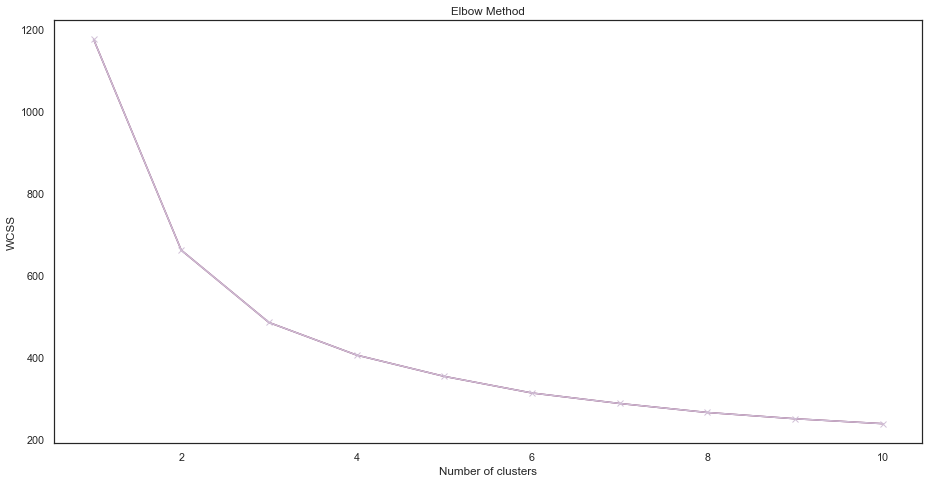

In [50]:
plt.figure(figsize=(16,8))
plt.plot(range(1, 11), wcss)
plt.title('The elbow method for optimal K')
plt.plot(range(1, 11), wcss,'bx-', color=COLORS[3])
plt.grid
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [51]:

kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")

kl.elbow

3

In [52]:
COLORS

['#7a2b5d',
 '#975c86',
 '#b38dad',
 '#d0bed6',
 '#edf0ff',
 '#eae1cd',
 '#e8d19a',
 '#e6c064',
 '#e3ae29']

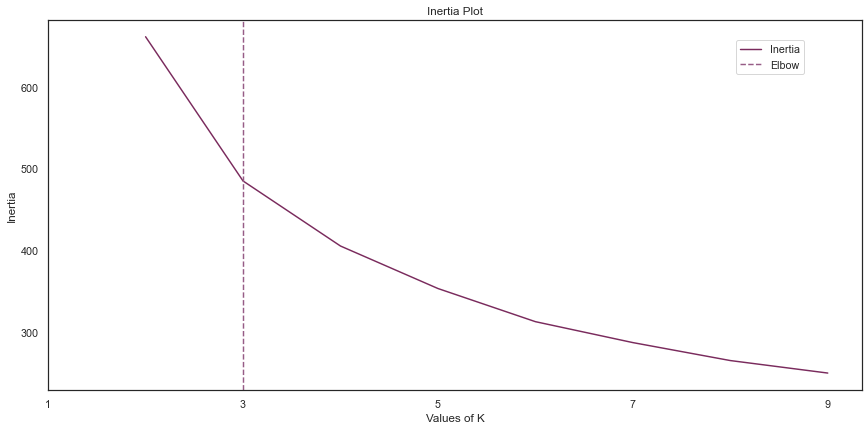

Knee located at k= 3


In [53]:
showElbowSilhouette(whinedf_kmeans, wine_feats_dec, max_k=10)

In [54]:
kmeans= KMeans(n_clusters=3, init='k-means++', max_iter=1000000,n_init=30,random_state=0)
label=kmeans.fit_predict(whinedf_kmeans)

whinedf_kmeans['label']=label
whinedf_kmeans.groupby('label').mean() #THIS SEEMS TO BE A GOOD SOLUTION

Dryred_dec  Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  \
label                                                                  
0        0.730068      0.025995   0.191806     0.026278     0.025391   
1        0.214341      0.159716   0.300788     0.163230     0.161712   
2        0.384597      0.081724   0.374480     0.080440     0.078735   

       Exotic_dec  
label              
0        0.115537  
1        0.449767  
2        0.107718

In [55]:
whinedf_kmeans['label'].value_counts()

0    4237
2    4181
1    1548
Name: label, dtype: int64

In [56]:
# Cluster 0 - People that mostly prefer Dryred wine 
# Cluster 1 - People that prefer Sweet wines the most (both red and white) as well as Dessert and exotic wines
# Cluster 2- People that prefer Drywhite the most, but also enjoy dryred wine

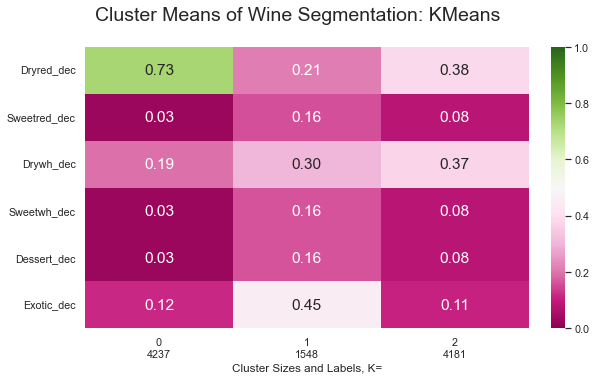

In [57]:
showClusterHeatMap_final(whinedf_kmeans, 'label', wine_feats_dec, 'Cluster Means of Wine Segmentation: KMeans')


### Hierarchical Clustering

In [58]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  
    
    sst = get_ss(df)  
    
    r2 = []  
    
    for i in range(min_nclus, max_nclus+1):  
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) 
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  
        
        
        ssb = sst - np.sum(ssw_labels) 
        
        
        r2.append(ssb / sst)  
        
    return np.array(r2)

In [59]:
## Code based from Lab 09
def plot_dendrogram(model, title, **kwargs):
    sns.set_palette(CAT_PALETTE)

    # Create linkage matrix and then plot the dendrogram
    
    fig, ax = plt.subplots(figsize=(11,5))
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    plt.hlines(kwargs['color_threshold'], 0, 1000, colors="r", linestyles="dashed")
    
    
    plt.xticks(rotation=90)
    plt.title(title)

    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    save_fig(title, fig)
    plt.show()
    
    sns.set_palette(DEFAULT_PALETTE)
    


In [60]:
whinedf_hier=df_nonoise[wine_feats_dec].copy() 

In [61]:

# Preparing the input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 7
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=whinedf_hier, link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)


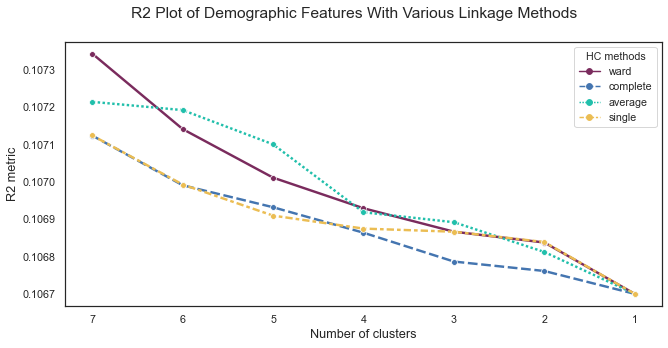

In [62]:
sns.set_palette(CAT_PALETTE)

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 Plot of Demographic Features With Various Linkage Methods", fontsize=16)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
save_fig('R2 plot for various hierarchical methods: Demographic Features', fig)
plt.show()

sns.set_palette(DEFAULT_PALETTE)


In [63]:
# setting distance_threshold=0 and n_clusters=None to compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(whinedf_hier)

array([9965, 8805, 8661, ...,    1,    2,    0])

In [64]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count


linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

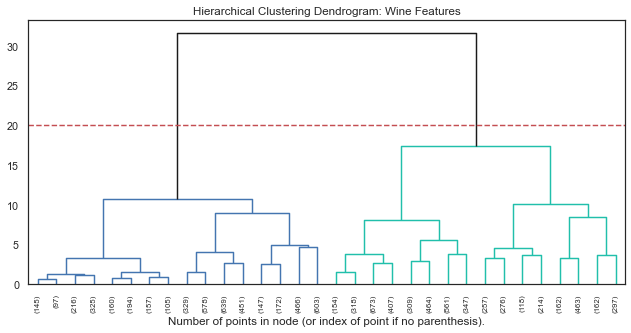

In [65]:

plot_dendrogram(hclust, title='Hierarchical Clustering Dendrogram: Wine Features',\
                truncate_mode="level", p=4, \
                above_threshold_color='k', color_threshold=20) #10.5)



In [66]:
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=2)
hc4_labels = hc4lust.fit_predict(whinedf_hier[wine_feats_dec])

df_concat = pd.concat((whinedf_hier, pd.Series(hc4_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean() #THIS SOLUTION IS TOO HOMOGENEOUS / Not good

Dryred_dec  Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  \
labels                                                                  
0.0       0.502346      0.071270   0.286768     0.070183     0.069200   
1.0       0.509379      0.068648   0.283365     0.069428     0.068876   

        Exotic_dec  
labels              
0.0       0.164306  
1.0       0.162318

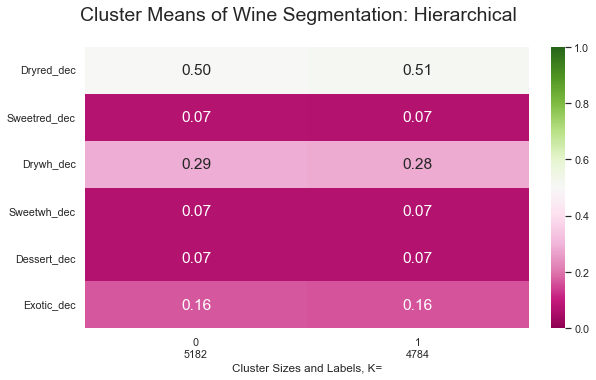

In [67]:
showClusterHeatMap_final(df_concat, 'labels', wine_feats_dec, 'Cluster Means of Wine Segmentation: Hierarchical')


### K-means into Hierarchical

In [68]:
whinedf_kmh=df_nonoise[wine_feats_dec].copy() 

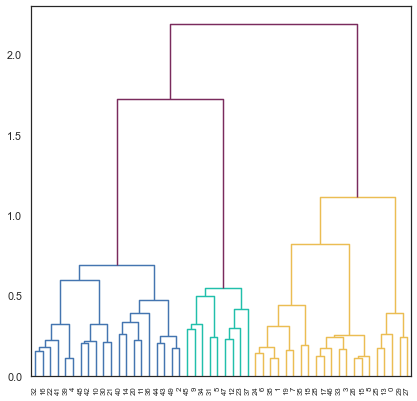

In [69]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy 

kmeans= KMeans(n_clusters=50, init='k-means++', max_iter=1000000,n_init=30, random_state=0)
label=kmeans.fit_predict(whinedf_kmh)
centroids=kmeans.cluster_centers_

Z = hierarchy.linkage(centroids, method = "ward")
sns.set_palette(CAT_PALETTE)
plt.figure(figsize=(7,7))
dendrogram(Z, orientation='top',distance_sort='descending',show_leaf_counts=True)
plt.show()
sns.set_palette(DEFAULT_PALETTE)

In [70]:
hc4lust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3) 
hc4_labels = hc4lust.fit_predict(whinedf_kmh)

whinedf_kmh['label']=hc4_labels
whinedf_kmh.groupby('label').mean() # THIS ALSO SEEMS TO BE A GOOD SOLUTION

Dryred_dec  Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  \
label                                                                  
0        0.707404      0.028010   0.207383     0.028439     0.028397   
1        0.241252      0.146998   0.318471     0.144674     0.148415   
2        0.364578      0.086165   0.380817     0.087324     0.081036   

       Exotic_dec  
label              
0        0.116940  
1        0.399128  
2        0.092422

In [71]:
whinedf_kmh['label'].value_counts()

0    4784
2    3233
1    1949
Name: label, dtype: int64

In [72]:
# Cluster 0 - People that prefer drywhite whine the most and also enjoy dryred wine
# Cluster 1 - People that prefer dryred whine the most
# Cluster 2- People that enjoy sweet whine the most (both red and white), as well as dessert and exotic whines

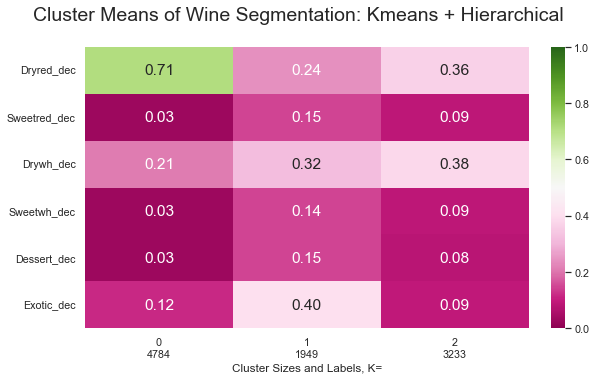

In [73]:
showClusterHeatMap_final(whinedf_kmh, 'label', wine_feats_dec, 'Cluster Means of Wine Segmentation: Kmeans + Hierarchical')


## Comparing the best cluster solutions /Profiling

### Kmeans

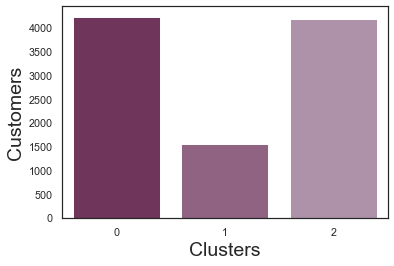

In [74]:
p= sns.countplot(x ='label', data = whinedf_kmeans) #Ploting number of customers per cluster
p.set_xlabel("Clusters", fontsize = 20)
p.set_ylabel("Customers", fontsize = 20)
    
# Show the plot
plt.show()

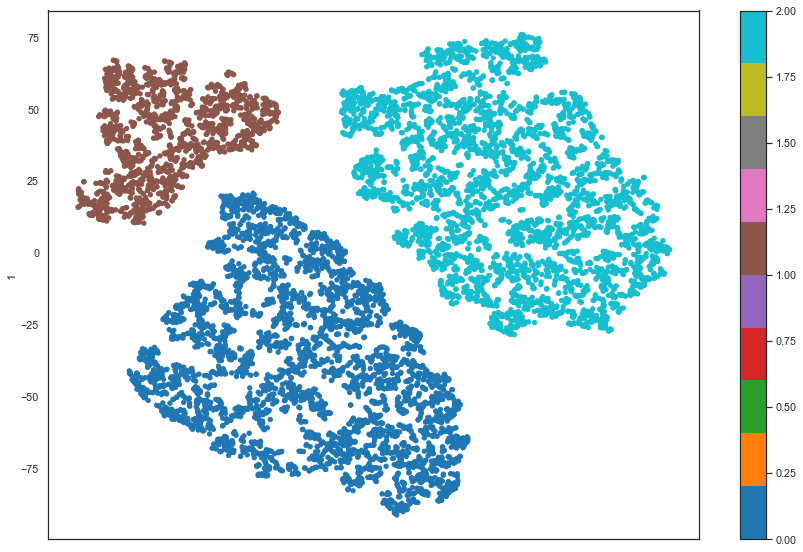

In [75]:
from sklearn.manifold import TSNE #tsne for visualizing the data in 2d
two_dim = TSNE(random_state=42).fit_transform(whinedf_kmeans)
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=whinedf_kmeans['label'], colormap='tab10', figsize=(15,10))
plt.show()

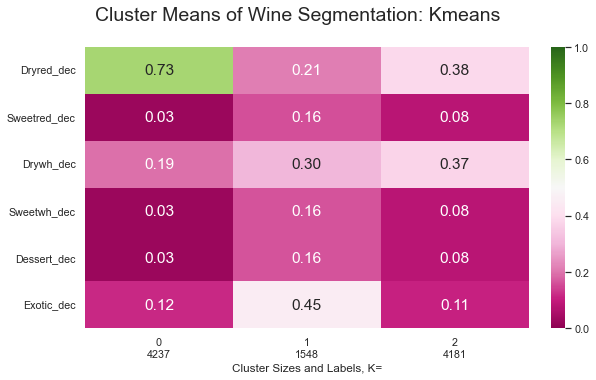

In [76]:
showClusterHeatMap_final(whinedf_kmeans, 'label', wine_feats_dec, 'Cluster Means of Wine Segmentation: Kmeans')


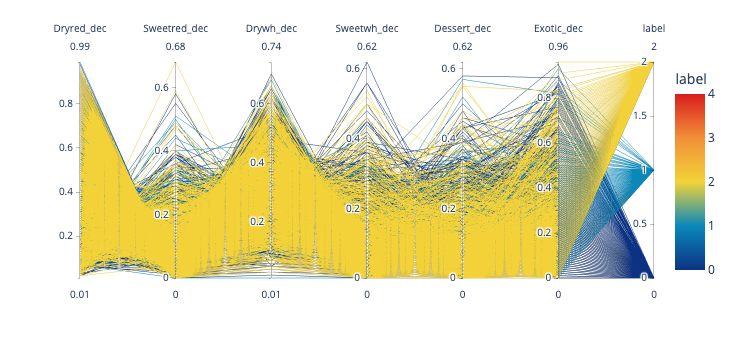

In [77]:
import plotly.express as px #Parallel coordinates plot to visualize the differences in each cluster

fig = px.parallel_coordinates(whinedf_kmeans, color="label",
                             color_continuous_scale=px.colors.diverging.Portland, color_continuous_midpoint=2)
fig.show()

### Kmeans into hierarchical

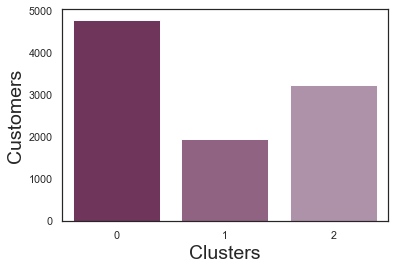

In [78]:
p= sns.countplot(x ='label', data = whinedf_kmh) #Ploting number of customers per cluster
p.set_xlabel("Clusters", fontsize = 20)
p.set_ylabel("Customers", fontsize = 20)
    
# Show the plot
plt.show()

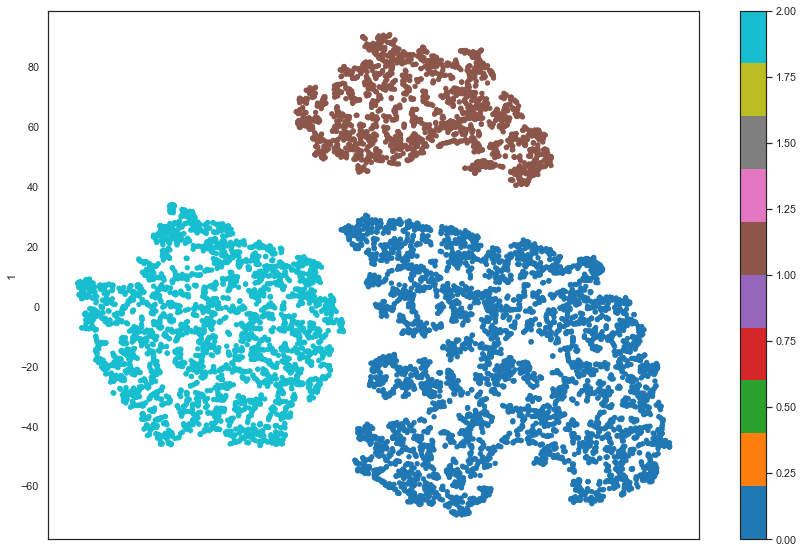

In [79]:
two_dim = TSNE(random_state=42).fit_transform(whinedf_kmh)
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=whinedf_kmh['label'], colormap='tab10', figsize=(15,10))
plt.show()

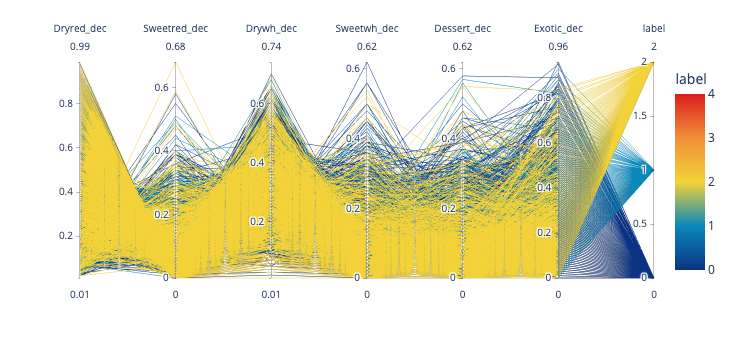

In [80]:
fig = px.parallel_coordinates(whinedf_kmh, color="label",
                             color_continuous_scale=px.colors.diverging.Portland, color_continuous_midpoint=2)
fig.show()

## Value Segmentation : Kmeans

In [81]:
df_vf = df[value_feats_mm]


In [82]:
df_vf.head()

Dayswus_mm   Freq_mm  Recency_mm    LTV_mm
Custid                                            
5325      0.147143  0.358491    0.032787  0.348824
3956      0.701429  0.660377    0.060109  0.401456
3681      0.165714  0.056604    0.102004  0.095745
2829      0.712857  0.018868    0.083789  0.096305
8788      0.410000  0.018868    0.005464  0.101904

In [83]:
kmeans = KMeans(n_init=15, random_state=42)

hclust = AgglomerativeClustering(compute_distances=True)

In [84]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

In [85]:
def clust_r2(df, kmeans, hclust, title='Continuous'):

    # Obtaining the R² scores for each cluster solution on continuous variables
    r2_scores = {}
    r2_scores['kmeans'] = get_r2_scores(df, kmeans)

    for linkage in ['complete', 'average', 'single', 'ward']:
        r2_scores[linkage] = get_r2_scores(
            df, hclust.set_params(linkage=linkage)
        )

    pd.DataFrame(r2_scores)

    # Visualizing the R² scores for each cluster solution on value/engagement variables
    pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

    plt.title(f"{title} Variables:\nR² plot for various clustering methods\n", fontsize=21)
    plt.legend(title="Cluster methods", title_fontsize=11)
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R² metric", fontsize=13)
    plt.show()

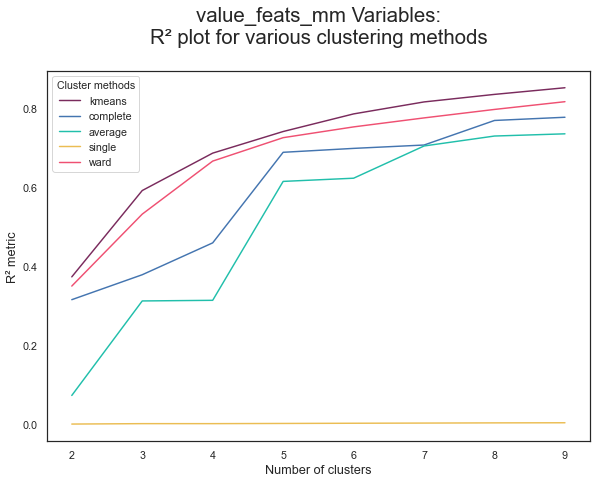

In [86]:
sns.set_palette(CAT_PALETTE)

clust_r2(df_vf, kmeans, hclust, 'value_feats_mm')

sns.set_palette(DEFAULT_PALETTE)


In [87]:
## Code based from sklearn documentation:
## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html?highlight=silhouette

def plotSilhouettes(X, max_clust, plot_dim, title = "Silhouette analysis for KMeans clustering with different K sizes"):
    range_n_clusters = range(2, max_clust+1)

    fig, axes = plt.subplots(plot_dim[0], plot_dim[1], sharex=True, figsize=(19,11))
    #fig.set_size_inches(11, 11)

    for ax, nclust in zip(axes.flatten(), range_n_clusters):
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(X) + (nclust + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=nclust, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(nclust):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            #color = cm.nipy_spectral(float(i) / nclust)
            color = COLORS[i]
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=14)

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title("The silhouette plot for K= "+ str(nclust) +" clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        
        plt.suptitle(
            title,
            fontsize=18,
            y=.95
        )
    save_fig(title, fig)
    plt.show()

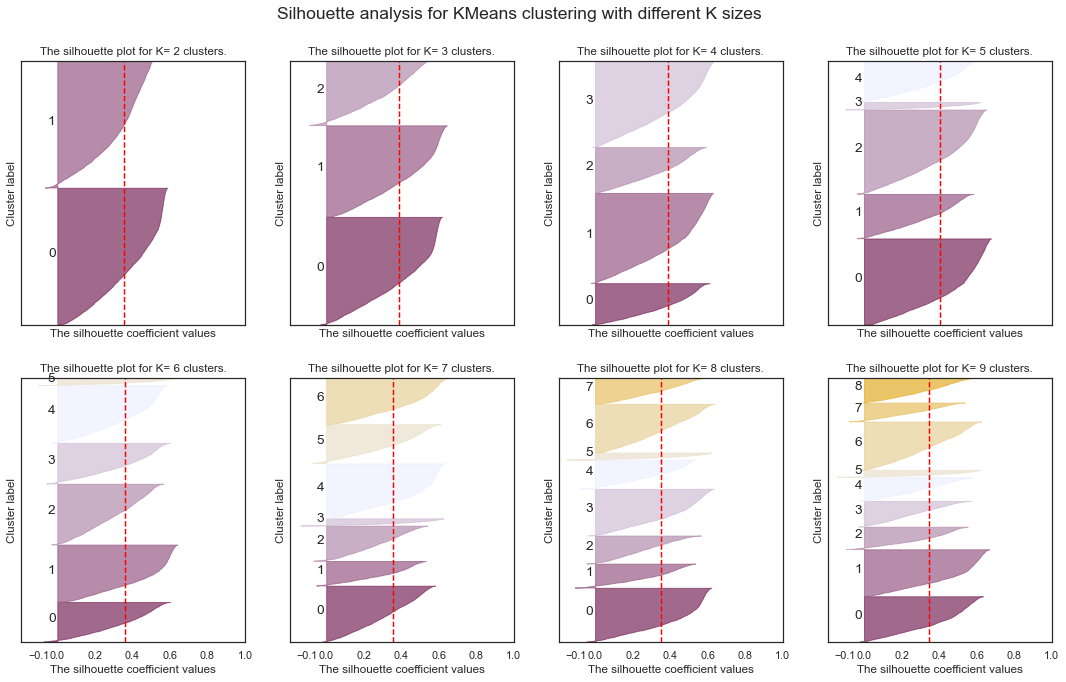

In [88]:
plotSilhouettes(df_vf, 9, [2,4])

In [89]:
# final cluster solution
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=42)
km_vf_labels = kmclust.fit_predict(df_vf)
km_vf_labels

array([0, 2, 1, ..., 1, 3, 2], dtype=int32)

In [90]:
# Characterizing the final clusters
df_vf_concat = pd.concat((df, pd.Series(km_vf_labels, name='labels')), axis=1)
df_vf_concat.groupby('labels').mean()

Dayswus        Age        Edu        Income       Freq    Recency  \
labels                                                                         
0.0     892.452290  48.086514  16.772901  70147.562977  14.778626  61.839695   
1.0     896.107940  48.612533  16.785433  70997.933071  15.112861  58.283793   
2.0     907.113019  47.917740  16.771817  69784.703863  14.564378  62.482833   
3.0     899.362359  47.455262  16.704834  69090.990401  14.206719  63.601303   

          Monetary         LTV    Perdeal     Dryred  ...  Dayswus_mm  \
labels                                                ...               
0.0     630.398219  211.961832  31.932570  51.315522  ...    0.489218   
1.0     646.809055  221.558071  31.562664  50.850394  ...    0.494440   
2.0     617.187411  201.694564  32.918455  50.852647  ...    0.510161   
3.0     601.387384  200.490230  32.944463  49.748372  ...    0.499089   

         Freq_mm  Recency_mm    LTV_mm  Dryred_dec  Sweetred_dec  Drywh_dec  \
labels                                                                        
0.0     0.259974    0.112641  0.218344    0.513155      0.068022   0.282564   
1.0     0.266280    0.106164  0.223717    0.508504      0.070820   0.284183   
2.0     0.255932    0.113812  0.212595    0.508526      0.069721   0.284671   
3.0     0.249183    0.115849  0.211921    0.497484      0.070370   0.287727   

        Sweetwh_dec  Dessert_dec  Exotic_dec  
labels                                        
0.0        0.067990     0.068098    0.162354  
1.0        0.069137     0.067119    0.160702  
2.0        0.068240     0.068376    0.165093  
3.0        0.072276     0.071885    0.165818  

[4 rows x 28 columns]

In [91]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_vf)

array([8097, 6877, 8362, ...,    1,    2,    0])

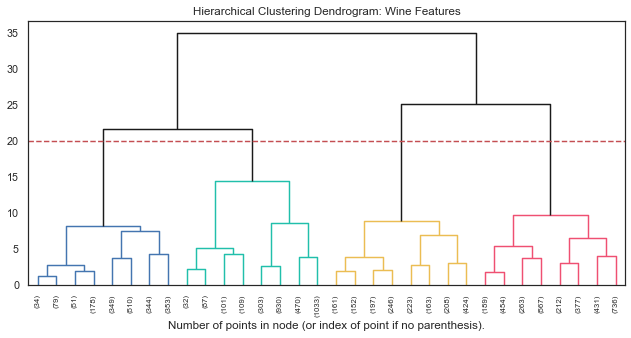

In [92]:

plot_dendrogram(hclust, title='Hierarchical Clustering Dendrogram: Wine Features',\
                truncate_mode="level", p=4, \
                above_threshold_color='k', color_threshold=20) #10.5)



In [93]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=4)
hc_vf_labels = hclust.fit_predict(df_vf)
hc_vf_labels

array([3, 2, 0, ..., 0, 0, 2])

In [94]:
#pd.Series(hc_vf_labels, name='labels')

In [95]:
#df_vf

In [96]:
linkage = 'ward'
distance = 'euclidean'
hclust_v = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hclust_v_labels = hclust_v.fit_predict(df_vf[value_feats_mm])

df_vf_concat = df_vf.copy()
df_vf_concat['labels'] = hclust_v_labels
df_vf_concat

Dayswus_mm   Freq_mm  Recency_mm    LTV_mm  labels
Custid                                                    
5325      0.147143  0.358491    0.032787  0.348824       3
3956      0.701429  0.660377    0.060109  0.401456       2
3681      0.165714  0.056604    0.102004  0.095745       0
2829      0.712857  0.018868    0.083789  0.096305       1
8788      0.410000  0.018868    0.005464  0.101904       0
...            ...       ...         ...       ...     ...
1383      0.831429  0.339623    0.107468  0.204367       1
4070      0.065714  0.320755    0.081967  0.318589       3
7909      0.098571  0.037736    0.118397  0.102464       0
4158      0.795714  0.000000    0.670310  0.100784       0
4914      0.612857  0.452830    0.051002  0.263718       2

[9966 rows x 5 columns]

In [97]:
# Characterizing the clusters
df_vf_concat.groupby('labels').mean()

Dayswus_mm   Freq_mm  Recency_mm    LTV_mm
labels                                            
0         0.249154  0.076254    0.151642  0.109015
1         0.728580  0.145971    0.097293  0.122095
2         0.761003  0.568729    0.092666  0.436224
3         0.257580  0.450146    0.089831  0.347388

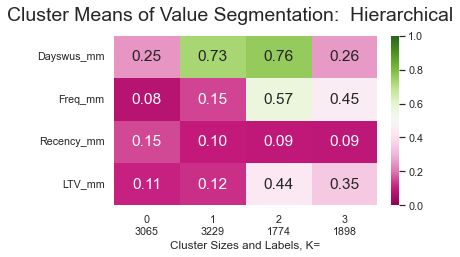

In [98]:
showClusterHeatMap_final(df_vf_concat, 'labels', value_feats_mm, 'Cluster Means of Value Segmentation:  Hierarchical')


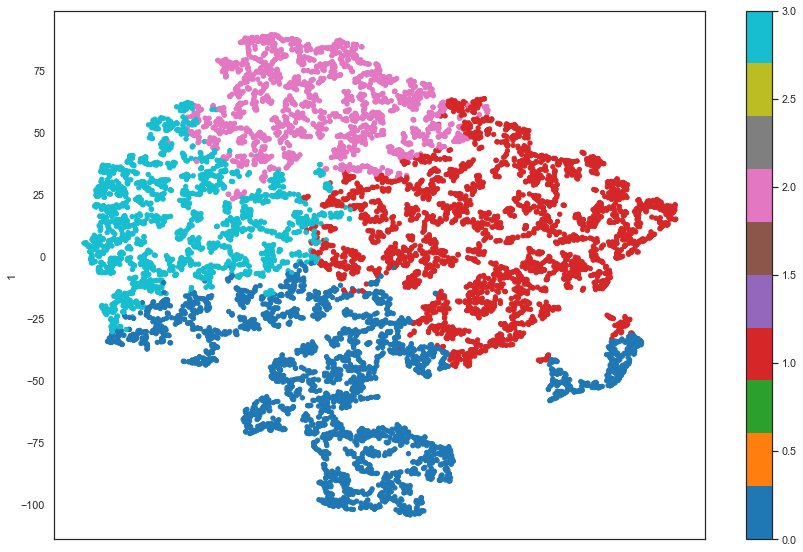

In [99]:
vtsne = TSNE(random_state=42).fit_transform(df_vf_concat[value_feats_mm])
pd.DataFrame(vtsne).plot.scatter(x=0, y=1, c=df_vf_concat['labels'], colormap='tab10', figsize=(15,10))
plt.show()